# Preface

Ada 1 folder, "reviews". Isinya datasets masih pisah-pisah. Nanti di combine di section "2. Testing with half-done".

Section "2. Testing with datasets...":
- Result combined nya jadi `compiled_reviews.csv`.
- Karena Date masih belum sesuai yang diinginin, aku nyoba pakek regex + timedelta dengan referensi waktu kapan code itu dijalanin. Succeeded.
- Aku include relevant columns aja di dataframe `cleaned_df`.

Section "3. Attempt prepro..."
- Aku redefine lagi functionnya, tapi tambahan sedikit exception/negasi. Ada file `exception_words.json` yang aku pakek untuk nge list kata-kata apa yang gak di process sebagai stopwords. Jadi kata-kata di file itu gak akan terhapus nanti. Mungkin bisa ditambahin nantinya.

Section 4. Attempt EDA
- Bisa kalian coba2 lagi. So far masih wordcloud dan bigrams/trigrams

Section 5. Attempt Feature Preps...
- Kalo mau coba modeling, langsung aja ke bagian ini. Rencana akan ada tokenizer juga di sini, sebelum modeling.



In [1]:
import pandas as pd
import asyncio
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import contractions
from googletrans import Translator
import json
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import nest_asyncio
nest_asyncio.apply()


In [2]:
# Init Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# init Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

In [3]:
translator = Translator()

In [4]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

---

---

# Skip aja part ini, testing doang

In [5]:
async def text_preprocessing_id(text):
    
    # Translate to Bahasa Indonesia
    
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        text = translated.text
    except Exception as e:
        print(f"Translation failed: {e}")
        return None  # Drop text if translation fails
    
    # Expand contractions
    text = contractions.fix(text)

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Hashtag removal
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (retain apostrophes)
    text = re.sub(r"[^A-Za-z\s']", " ", text)
    
    # repeat letter removal
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Slang words replacement
    tokens = [slang_dict[word] if word in slang_dict else word for word in tokens]

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_id or word in {"tidak", "belum", "jangan", "enggak", "gak"}]

    # Stemming (using Sastrawi for Bahasa Indonesia)
    tokens = [stemmer_id.stem(word) for word in tokens]

    # Combine tokens
    text = ' '.join(tokens)

    return text


In [6]:
# samples
sample_reviews_id = [
    "Pengiriman sangat lambat dan pegawai tidak ramah. #mengecewakan",
    "Pelayanan sangat baik! Cepat dan murah. Sangat direkomendasikan.",
    "Saya harus menunggu 3 jam di gudang. @perusahaan tidak bisa diterima!",
    "Can you be like the others? I'm very disappointed with your services.",
    "Kntl", 
    """He! sby-mlg perjalanan mosok iyo 3 hari. mau dikirim dari jam 7 pagi. jarak warehouse kerumah naik sepeda motor 5 menit!!!! yo wes seharian gak ono kabar
ngerti gak, expedisi lain dikasih kontak kurirnya! ini opooo -_-
ujung e gagal kirim !
dari jaman gak ada shopee tokped sek bermasalah ae
tutup ae gak akan bertahan yoan mending wahana/jnt terutama tiki /shopee express

shopee ngasih kompensasi gak tepat waktu gara2 kerjomu ngerti gak
kerja nyari berkah iki nyari dihujat orang kok yo iso makan keringat hasil grundelan e orang -_-

bubar ae gak guna

wes lah besok2 dapat jne mending dibatalno ae -_-
    """,
    "Kntl asu, pukimak, babi, bubar ae cok. Gak guna!",
    "Kulo kok rada kecewa kaliyan pelayanan kurir punika. Paket sing mesthine tekan sesuk, malah telat tekan nganti 3 dinten. Sing langkung parah, paket punika mboten dipunparingi kabar punapa-punapa, lan kulo kedah ngontak layanan pelanggan piyambak.",
    "Apo jo kurir kini? Jan langsuang kasiah barek! Paket nan awak kirim tibo-tibo ado di mana, lapau indak jelas, tarang tuan-tuan indak ado kabar! Jan ambo baliak-baliak mangecek ka call center, malah awak pulo nan mangambek! Cakak bana pelayanannyo, indak ado adab! Awak bayia mahal-mahal, alah kironyo mah pelayanan macam indak ado otak! Tolong lah, jangan macam ini lai ke depan",
    "JNE pungo, hana utak, hanjeut meupike gob rugo, lage bui…😂😂",
    "Jne paleh lehoho kah me barang , ka pike hayeu tat kah nyan. Ok me jih keuh. Kon kah manteng hayeu! lhe lom expedisi selain kah."
]

# make dataframe
df_test_id = pd.DataFrame(sample_reviews_id, columns=["review"])

# 

In [7]:
# apply text preprocessing
# df_test_id["processed_review"] = df_test_id["review"].apply(text_preprocessing_id)

In [8]:
# Async loop to process reviews
async def process_reviews():
    df_test_id["processed_review"] = await asyncio.gather(
        *[text_preprocessing_id(text) for text in df_test_id["review"]]
    )

In [9]:
await process_reviews()

In [10]:
# Display the original and processed reviews
df_test_id

,review,processed_review
0,Pengiriman sangat lambat dan pegawai tidak ram...,kirim lambat pegawai tidak ramah
1,Pelayanan sangat baik! Cepat dan murah. Sangat...,layan cepat murah rekomendasi
2,Saya harus menunggu 3 jam di gudang. @perusaha...,tunggu jam gudang tidak terima
3,Can you be like the others? I'm very disappoin...,kecewa layan
4,Kntl,kontol
5,He! sby-mlg perjalanan mosok iyo 3 hari. mau d...,he sby mlg jalan iya kirim jam pagi jarak ware...
6,"Kntl asu, pukimak, babi, bubar ae cok. Gak guna!",kontol asu pukimak babi tutup cok tidak guna
7,Kulo kok rada kecewa kaliyan pelayanan kurir p...,kecewa jasa kurir paket besok tunda buruk pake...
8,Apo jo kurir kini? Jan langsuang kasiah barek!...,kurir jangan langsung jatuh cinta paket kirim ...
9,"JNE pungo, hana utak, hanjeut meupike gob rugo...",kurir gila tidak otak tidak mikir orang kalah ...


In [11]:
pd.set_option('display.max_colwidth', None)

# Display the original and processed reviews
df_test_id

,review,processed_review
0,Pengiriman sangat lambat dan pegawai tidak ramah. #mengecewakan,kirim lambat pegawai tidak ramah
1,Pelayanan sangat baik! Cepat dan murah. Sangat direkomendasikan.,layan cepat murah rekomendasi
2,Saya harus menunggu 3 jam di gudang. @perusahaan tidak bisa diterima!,tunggu jam gudang tidak terima
3,Can you be like the others? I'm very disappointed with your services.,kecewa layan
4,Kntl,kontol
5,"He! sby-mlg perjalanan mosok iyo 3 hari. mau dikirim dari jam 7 pagi. jarak warehouse kerumah naik sepeda motor 5 menit!!!! yo wes seharian gak ono kabar\nngerti gak, expedisi lain dikasih kontak kurirnya! ini opooo -_-\nujung e gagal kirim !\ndari jaman gak ada shopee tokped sek bermasalah ae\ntutup ae gak akan bertahan yoan mending wahana/jnt terutama tiki /shopee express\n\nshopee ngasih kompensasi gak tepat waktu gara2 kerjomu ngerti gak\nkerja nyari berkah iki nyari dihujat orang kok yo iso makan keringat hasil grundelan e orang -_-\n\nbubar ae gak guna\n\nwes lah besok2 dapat jne mending dibatalno ae -_-\n",he sby mlg jalan iya kirim jam pagi jarak warehouse rumah sepeda motor menit iya hari tidak kabar erti tidak expedisi kasih kontak kurir ujung e gagal kirim jaman tidak shopee tokped sek masalah tutup tidak tahan yoan lebih baik wahana jnt tik shopee express shopee kompensasi tidak gara kerjomu erti tidak kerja cari berkah cari hujat orang iya iso makan keringat hasil grundelan e orang tutup tidak besok kurir lebih baik dibatalno
6,"Kntl asu, pukimak, babi, bubar ae cok. Gak guna!",kontol asu pukimak babi tutup cok tidak guna
7,"Kulo kok rada kecewa kaliyan pelayanan kurir punika. Paket sing mesthine tekan sesuk, malah telat tekan nganti 3 dinten. Sing langkung parah, paket punika mboten dipunparingi kabar punapa-punapa, lan kulo kedah ngontak layanan pelanggan piyambak.",kecewa jasa kurir paket besok tunda buruk paket tidak pemberitahuan hubung layan langgan
8,"Apo jo kurir kini? Jan langsuang kasiah barek! Paket nan awak kirim tibo-tibo ado di mana, lapau indak jelas, tarang tuan-tuan indak ado kabar! Jan ambo baliak-baliak mangecek ka call center, malah awak pulo nan mangambek! Cakak bana pelayanannyo, indak ado adab! Awak bayia mahal-mahal, alah kironyo mah pelayanan macam indak ado otak! Tolong lah, jangan macam ini lai ke depan",kurir jangan langsung jatuh cinta paket kirim kafe tidak tidak kabar jangan biar bicara call center kau blokir layan buruk tidak sopan santun bayar mahal mah layan tidak otak tolong jangan laku
9,"JNE pungo, hana utak, hanjeut meupike gob rugo, lage bui…😂😂",kurir gila tidak otak tidak mikir orang kalah kaya tahan


---

# 1. (Skip aja) testing with sample scrapped

In [12]:
# load the dataset
df = pd.read_csv('test.csv')

In [13]:
df

,ID,Name,Rating,Reviews,Date
0,0,Irynt S,0,"Kurirnya ga sopan. Kronologisnya, kurir nelpon sy 6 kali dengan rentang waktu 1 menit tiap telepon, sy saat itu tidak lg pegang hp krn sedang kerja. Waktu sy telpon balik 10 menit kemudian katanya tidak bsa antar paket lagi krn dia tidak …",6 bulan lalu
1,1,Masrizal Mahmud,0,"Muak dengan kinerja JNE Banda Aceh. Di tracking disebutkan barang sedang diantar kurir, dua hari berturut2. Waktu kantornya saya datangi, tiba2 secara ajaib barang keluar dari gudang dalam 1 menit. Trus yg diantar kurir apa? Tuyul? Kejadian …",4 tahun lalu
2,2,Sartivina Br ginting,0,"Jne sampah, kerjanya apa si cmn tgl ngantar kan brg aja di tahan"" ,udh express juga,karna org perlu cepat ini ditahan tahan ,udah la paketnya isinya mahal",6 bulan lalu
3,3,Adex Sari,0,"Di trucking paket sudah diterima,, foto alamat ntah dmna"" gak sesuai sama alamat yg sudah saya terakan..\nPadahal alamat sudah jelas kantor daihatsu …",9 bulan lalu
4,4,Tasya Rania Insyara,0,gak jelas banget jam operasionalnya\ndi maps dibikin buka setiap hari\ndatang di hari sabtu dan minggu ternyata gak buka …,10 bulan lalu
...,...,...,...,...,...
969,354,Sultan Andrews Abieza,3,No review found,5 tahun lalu
970,355,Andri Awan,4,No review found,5 tahun lalu
971,356,Muhammad Taufik,3,No review found,5 tahun lalu
972,357,cici nurrahmah,5,No review found,6 tahun lalu


In [14]:
df['Rating'].value_counts()

Rating
1    388
0    256
5    168
3     74
4     56
2     32
Name: count, dtype: int64

In [15]:
# devide bad and good reviews
## bad reviews = 1 - 3 stars
## good reviews = 4 - 5 stars

bad_reviews_df = df[df['Rating'] <= 3]
good_reviews_df = df[df['Rating'] > 3]

In [16]:
df['Reviews'][df['Reviews'] == 'No review found'].count()

248

In [17]:
bad_reviews_df

,ID,Name,Rating,Reviews,Date
0,0,Irynt S,0,"Kurirnya ga sopan. Kronologisnya, kurir nelpon sy 6 kali dengan rentang waktu 1 menit tiap telepon, sy saat itu tidak lg pegang hp krn sedang kerja. Waktu sy telpon balik 10 menit kemudian katanya tidak bsa antar paket lagi krn dia tidak …",6 bulan lalu
1,1,Masrizal Mahmud,0,"Muak dengan kinerja JNE Banda Aceh. Di tracking disebutkan barang sedang diantar kurir, dua hari berturut2. Waktu kantornya saya datangi, tiba2 secara ajaib barang keluar dari gudang dalam 1 menit. Trus yg diantar kurir apa? Tuyul? Kejadian …",4 tahun lalu
2,2,Sartivina Br ginting,0,"Jne sampah, kerjanya apa si cmn tgl ngantar kan brg aja di tahan"" ,udh express juga,karna org perlu cepat ini ditahan tahan ,udah la paketnya isinya mahal",6 bulan lalu
3,3,Adex Sari,0,"Di trucking paket sudah diterima,, foto alamat ntah dmna"" gak sesuai sama alamat yg sudah saya terakan..\nPadahal alamat sudah jelas kantor daihatsu …",9 bulan lalu
4,4,Tasya Rania Insyara,0,gak jelas banget jam operasionalnya\ndi maps dibikin buka setiap hari\ndatang di hari sabtu dan minggu ternyata gak buka …,10 bulan lalu
...,...,...,...,...,...
967,352,Irvan Verdian,3,No review found,5 tahun lalu
968,353,Mustafa Kamal,2,No review found,5 tahun lalu
969,354,Sultan Andrews Abieza,3,No review found,5 tahun lalu
971,356,Muhammad Taufik,3,No review found,5 tahun lalu


In [18]:
# drop rows with 'No review found'
bad_reviews_df = bad_reviews_df[bad_reviews_df['Reviews'] != 'No review found']

In [19]:
bad_reviews_df

,ID,Name,Rating,Reviews,Date
0,0,Irynt S,0,"Kurirnya ga sopan. Kronologisnya, kurir nelpon sy 6 kali dengan rentang waktu 1 menit tiap telepon, sy saat itu tidak lg pegang hp krn sedang kerja. Waktu sy telpon balik 10 menit kemudian katanya tidak bsa antar paket lagi krn dia tidak …",6 bulan lalu
1,1,Masrizal Mahmud,0,"Muak dengan kinerja JNE Banda Aceh. Di tracking disebutkan barang sedang diantar kurir, dua hari berturut2. Waktu kantornya saya datangi, tiba2 secara ajaib barang keluar dari gudang dalam 1 menit. Trus yg diantar kurir apa? Tuyul? Kejadian …",4 tahun lalu
2,2,Sartivina Br ginting,0,"Jne sampah, kerjanya apa si cmn tgl ngantar kan brg aja di tahan"" ,udh express juga,karna org perlu cepat ini ditahan tahan ,udah la paketnya isinya mahal",6 bulan lalu
3,3,Adex Sari,0,"Di trucking paket sudah diterima,, foto alamat ntah dmna"" gak sesuai sama alamat yg sudah saya terakan..\nPadahal alamat sudah jelas kantor daihatsu …",9 bulan lalu
4,4,Tasya Rania Insyara,0,gak jelas banget jam operasionalnya\ndi maps dibikin buka setiap hari\ndatang di hari sabtu dan minggu ternyata gak buka …,10 bulan lalu
...,...,...,...,...,...
843,228,Solong To YOU BABE,2,Tidak buruk,7 tahun lalu
844,229,Novan 87,1,Pelayanan baaaddddd.....,7 tahun lalu
845,230,Bachtiar Arrahman,2,Respon lambat,2 tahun lalu
847,232,Syifa Alisha,3,Hmmmmm,6 tahun lalu


In [20]:
bad_reviews_df_prepo = bad_reviews_df.copy()
async def preprocess_reviews():
    bad_reviews_df_prepo['processed_review'] = await asyncio.gather(
        *[text_preprocessing_id(review) for review in bad_reviews_df_prepo['Reviews']]
    )

await preprocess_reviews()

In [21]:
bad_reviews_df_prepo

,ID,Name,Rating,Reviews,Date,processed_review
0,0,Irynt S,0,"Kurirnya ga sopan. Kronologisnya, kurir nelpon sy 6 kali dengan rentang waktu 1 menit tiap telepon, sy saat itu tidak lg pegang hp krn sedang kerja. Waktu sy telpon balik 10 menit kemudian katanya tidak bsa antar paket lagi krn dia tidak …",6 bulan lalu,kurir tidak sopan kronologis kurir nelpon kali rentang menit telepon tidak pegang handphone kerja telpon menit tidak paket tidak
1,1,Masrizal Mahmud,0,"Muak dengan kinerja JNE Banda Aceh. Di tracking disebutkan barang sedang diantar kurir, dua hari berturut2. Waktu kantornya saya datangi, tiba2 secara ajaib barang keluar dari gudang dalam 1 menit. Trus yg diantar kurir apa? Tuyul? Kejadian …",4 tahun lalu,muak kerja kurir banda aceh tracking barang antar kurir kantor datang ajaib barang gudang menit trus antar kurir tuyul jadi
2,2,Sartivina Br ginting,0,"Jne sampah, kerjanya apa si cmn tgl ngantar kan brg aja di tahan"" ,udh express juga,karna org perlu cepat ini ditahan tahan ,udah la paketnya isinya mahal",6 bulan lalu,kurir sampah kerja si cmn tanggal ngantar bareng tahan udh express orang cepat tahan tahan paket isi mahal
3,3,Adex Sari,0,"Di trucking paket sudah diterima,, foto alamat ntah dmna"" gak sesuai sama alamat yg sudah saya terakan..\nPadahal alamat sudah jelas kantor daihatsu …",9 bulan lalu,trucking paket terima foto alamat ntah dmna tidak sesuai alamat tera alamat kantor daihatsu
4,4,Tasya Rania Insyara,0,gak jelas banget jam operasionalnya\ndi maps dibikin buka setiap hari\ndatang di hari sabtu dan minggu ternyata gak buka …,10 bulan lalu,tidak banget jam operasional maps bikin buka sabtu minggu tidak buka
...,...,...,...,...,...,...
843,228,Solong To YOU BABE,2,Tidak buruk,7 tahun lalu,tidak buruk
844,229,Novan 87,1,Pelayanan baaaddddd.....,7 tahun lalu,layan bad
845,230,Bachtiar Arrahman,2,Respon lambat,2 tahun lalu,respon lambat
847,232,Syifa Alisha,3,Hmmmmm,6 tahun lalu,hm


---

# 2. Testing scraped datasets
Untuk script combining berbagai datasets, dan bersih-bersih. Kayak transform date ke date type.

In [22]:
# combine the datasets
# Define the folder path
folder_path = './reviews'

# Initialize an empty list to store dataframes
dataframes = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # Check if the file is a CSV
        file_path = os.path.join(folder_path, file_name)
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        # Optionally add a column to track the source file
        df['Source'] = file_name
        # Append the dataframe to the list
        dataframes.append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined dataframe to a CSV file
output_path = 'compiled_reviews.csv'
combined_df.to_csv(output_path, index=False)

print(f"Combined dataframe saved to {output_path}")


Combined dataframe saved to compiled_reviews.csv


In [23]:
final_df = pd.read_csv('compiled_reviews.csv')

In [24]:
final_df

,Rating,Reviews,Date,Company,Province,Source
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",9 months ago,JNE,Aceh,JNE_Aceh.csv
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",4 years ago,JNE,Aceh,JNE_Aceh.csv
2,5,"Nice Place, they're working on rebuild their office, great people and services",3 years ago,JNE,Aceh,JNE_Aceh.csv
3,5,Good delivery service for customers in this country.,2 years ago,JNE,Aceh,JNE_Aceh.csv
4,5,Good service,3 years ago,JNE,Aceh,JNE_Aceh.csv
...,...,...,...,...,...,...
27160,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27161,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27162,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27163,2,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv


In [25]:
# remove rows with 'No review found'
final_df = final_df[final_df['Reviews'] != 'No review found']

In [26]:
final_df.shape

(18090, 6)

In [27]:
final_df.isnull().sum()

Rating          0
Reviews         0
Date        17787
Company         0
Province        0
Source          0
dtype: int64

In [28]:
# # fill nan values in Date column with "6 months ago"
# final_df['Date'] = final_df['Date'].fillna('6 months ago')

# Calculate the mode of the 'Date' column
mode_value = final_df['Date'].mode()[0]

# Fill NaN values in the 'Date' column with the mode
final_df['Date'] = final_df['Date'].fillna(mode_value)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\2744177037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Date'] = final_df['Date'].fillna(mode_value)


In [29]:
final_df.isna().sum()

Rating      0
Reviews     0
Date        0
Company     0
Province    0
Source      0
dtype: int64

In [30]:
final_df

,Rating,Reviews,Date,Company,Province,Source
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",9 months ago,JNE,Aceh,JNE_Aceh.csv
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",4 years ago,JNE,Aceh,JNE_Aceh.csv
2,5,"Nice Place, they're working on rebuild their office, great people and services",3 years ago,JNE,Aceh,JNE_Aceh.csv
3,5,Good delivery service for customers in this country.,2 years ago,JNE,Aceh,JNE_Aceh.csv
4,5,Good service,3 years ago,JNE,Aceh,JNE_Aceh.csv
...,...,...,...,...,...,...
27080,1,Kargo Silambat,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27081,1,SILELET CEMBRETTTTTT,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27082,1,Lambat sekali....,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27083,1,KERAS!!!!!,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv


In [31]:
# let's translate the Date column to bahasa indonesia first
## def func to tran
async def translate_to_indonesian_async(text):
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        return translated.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

In [32]:
async def translate_column(df, column_name):
    tasks = [translate_to_indonesian_async(text) for text in df[column_name]]
    translated_texts = await asyncio.gather(*tasks)
    df[f"{column_name}_translated"] = translated_texts

In [33]:
await translate_column(final_df, "Date")

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\3877582011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_translated"] = translated_texts


In [34]:
final_df

,Rating,Reviews,Date,Company,Province,Source,Date_translated
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",9 months ago,JNE,Aceh,JNE_Aceh.csv,9 bulan yang lalu
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",4 years ago,JNE,Aceh,JNE_Aceh.csv,4 tahun yang lalu
2,5,"Nice Place, they're working on rebuild their office, great people and services",3 years ago,JNE,Aceh,JNE_Aceh.csv,3 tahun yang lalu
3,5,Good delivery service for customers in this country.,2 years ago,JNE,Aceh,JNE_Aceh.csv,2 tahun yang lalu
4,5,Good service,3 years ago,JNE,Aceh,JNE_Aceh.csv,3 tahun yang lalu
...,...,...,...,...,...,...,...
27080,1,Kargo Silambat,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu
27081,1,SILELET CEMBRETTTTTT,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu
27082,1,Lambat sekali....,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu
27083,1,KERAS!!!!!,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu


In [35]:
# let's attempt to transform the date
## def the func

def parse_time_ago(time_ago):
    current_time = datetime.now()
    
    # Match cases with explicit numbers
    match = re.match(r"(\d+)\s+(\w+)", time_ago)
    if match:
        value, unit = int(match.group(1)), match.group(2)
    else:
        # Handle "sehari", "seminggu", "sebulan", "setahun" cases
        if time_ago.startswith('se'):
            value, unit = 1, time_ago.split()[0][2:]  # Extract the unit after "se"
        else:
            return None  # If it doesn't match any known format, return None
    
    # Map units to timedelta
    if unit.startswith('menit'):
        return current_time - timedelta(minutes=value)
    elif unit.startswith('jam'):
        return current_time - timedelta(hours=value)
    elif unit.startswith('hari'):
        return current_time - timedelta(days=value)
    elif unit.startswith('minggu'):
        return current_time - timedelta(weeks=value)
    elif unit.startswith('bulan'):
        # Approximate 1 month = 30 days
        return current_time - timedelta(days=value * 30)
    elif unit.startswith('tahun'):
        # Approximate 1 year = 365 days
        return current_time - timedelta(days=value * 365)
    return None


In [36]:
final_df['parsed_date'] = final_df['Date_translated'].apply(parse_time_ago)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\2538609799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['parsed_date'] = final_df['Date_translated'].apply(parse_time_ago)


In [37]:
final_df

,Rating,Reviews,Date,Company,Province,Source,Date_translated,parsed_date
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",9 months ago,JNE,Aceh,JNE_Aceh.csv,9 bulan yang lalu,2024-04-24 11:58:20.105654
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",4 years ago,JNE,Aceh,JNE_Aceh.csv,4 tahun yang lalu,2021-01-20 11:58:20.105654
2,5,"Nice Place, they're working on rebuild their office, great people and services",3 years ago,JNE,Aceh,JNE_Aceh.csv,3 tahun yang lalu,2022-01-20 11:58:20.105654
3,5,Good delivery service for customers in this country.,2 years ago,JNE,Aceh,JNE_Aceh.csv,2 tahun yang lalu,2023-01-20 11:58:20.105654
4,5,Good service,3 years ago,JNE,Aceh,JNE_Aceh.csv,3 tahun yang lalu,2022-01-20 11:58:20.105654
...,...,...,...,...,...,...,...,...
27080,1,Kargo Silambat,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200
27081,1,SILELET CEMBRETTTTTT,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200
27082,1,Lambat sekali....,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200
27083,1,KERAS!!!!!,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200


In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 0 to 27084
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Rating           18090 non-null  int64         
 1   Reviews          18090 non-null  object        
 2   Date             18090 non-null  object        
 3   Company          18090 non-null  object        
 4   Province         18090 non-null  object        
 5   Source           18090 non-null  object        
 6   Date_translated  18090 non-null  object        
 7   parsed_date      18090 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.2+ MB


In [39]:
final_df

,Rating,Reviews,Date,Company,Province,Source,Date_translated,parsed_date
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",9 months ago,JNE,Aceh,JNE_Aceh.csv,9 bulan yang lalu,2024-04-24 11:58:20.105654
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",4 years ago,JNE,Aceh,JNE_Aceh.csv,4 tahun yang lalu,2021-01-20 11:58:20.105654
2,5,"Nice Place, they're working on rebuild their office, great people and services",3 years ago,JNE,Aceh,JNE_Aceh.csv,3 tahun yang lalu,2022-01-20 11:58:20.105654
3,5,Good delivery service for customers in this country.,2 years ago,JNE,Aceh,JNE_Aceh.csv,2 tahun yang lalu,2023-01-20 11:58:20.105654
4,5,Good service,3 years ago,JNE,Aceh,JNE_Aceh.csv,3 tahun yang lalu,2022-01-20 11:58:20.105654
...,...,...,...,...,...,...,...,...
27080,1,Kargo Silambat,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200
27081,1,SILELET CEMBRETTTTTT,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200
27082,1,Lambat sekali....,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200
27083,1,KERAS!!!!!,4 tahun lalu,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv,4 tahun lalu,2021-01-20 11:58:20.135200


In [40]:
final_df.columns

Index(['Rating', 'Reviews', 'Date', 'Company', 'Province', 'Source',
       'Date_translated', 'parsed_date'],
      dtype='object')

In [41]:
# make copy with relevant columns
cleaned_df = final_df[['Rating', 'Reviews', 'Company', 'Province', 'parsed_date']]

In [42]:
cleaned_df

,Rating,Reviews,Company,Province,parsed_date
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",JNE,Aceh,2024-04-24 11:58:20.105654
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",JNE,Aceh,2021-01-20 11:58:20.105654
2,5,"Nice Place, they're working on rebuild their office, great people and services",JNE,Aceh,2022-01-20 11:58:20.105654
3,5,Good delivery service for customers in this country.,JNE,Aceh,2023-01-20 11:58:20.105654
4,5,Good service,JNE,Aceh,2022-01-20 11:58:20.105654
...,...,...,...,...,...
27080,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200
27081,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200
27082,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200
27083,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200


In [43]:
# Standardize column names
cleaned_df.columns = cleaned_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [44]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 0 to 27084
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rating       18090 non-null  int64         
 1   reviews      18090 non-null  object        
 2   company      18090 non-null  object        
 3   province     18090 non-null  object        
 4   parsed_date  18090 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 848.0+ KB


In [45]:
cleaned_df.duplicated().sum()

422

In [46]:
cleaned_df[cleaned_df.duplicated()]

,rating,reviews,company,province,parsed_date
301,5,Bereh,JNE,Aceh,2021-01-20 11:58:20.105654
720,5,Oke,JNE,Bangka Belitung,2021-01-20 11:58:20.105654
739,5,Oke,JNE,Bangka Belitung,2021-01-20 11:58:20.105654
740,5,Oke,JNE,Bangka Belitung,2021-01-20 11:58:20.105654
744,5,Oke,JNE,Bangka Belitung,2021-01-20 11:58:20.105654
...,...,...,...,...,...
24832,5,Oke,Sicepat,Lampung,2021-01-20 11:58:20.134217
25318,5,Mantap,Sicepat,Papua Tengah,2021-01-20 11:58:20.134217
25527,5,Oke,Sicepat,Riau,2021-01-20 11:58:20.134217
26352,5,Baik,Sicepat,Sulawesi Utara,2021-01-20 11:58:20.135200


In [47]:
# drop dupes
cleaned_df.drop_duplicates(inplace=True)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\284287453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop_duplicates(inplace=True)


In [48]:
cleaned_df.duplicated().sum()

0

In [49]:
cleaned_df.to_csv('cleaned_reviews.csv', index=False)

---

# 3. Attempt preprocessing

In [50]:
with open('exception_words.json', 'r') as file:
    exception_data = json.load(file)

# Extract the list of exception words
exception_words = set(exception_data["exception_words"])

In [51]:
with open('cleaned_reviews.csv', 'r') as file_cleaned:
    bersih_df = pd.read_csv(file_cleaned)

In [52]:
bersih_df

,rating,reviews,company,province,parsed_date
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",JNE,Aceh,2024-04-24 11:58:20.105654
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",JNE,Aceh,2021-01-20 11:58:20.105654
2,5,"Nice Place, they're working on rebuild their office, great people and services",JNE,Aceh,2022-01-20 11:58:20.105654
3,5,Good delivery service for customers in this country.,JNE,Aceh,2023-01-20 11:58:20.105654
4,5,Good service,JNE,Aceh,2022-01-20 11:58:20.105654
...,...,...,...,...,...
17663,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200
17664,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200
17665,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200
17666,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200


In [53]:
## reinit just to make sure

# Init Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# init Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

translator = Translator()

In [54]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

In [55]:
# expand stopwords
# Load additional stopwords
with open('expand_stopwords.json', 'r') as f:
    custom_stopwords = json.load(f)["expand_stopwords"]
stpwds_id = set(stpwds_id + custom_stopwords)

In [56]:
# let's redefine the func. cs it's so far above there....

async def text_preprocessing_id(text):
    
    # Translate to Bahasa Indonesia
    
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        text = translated.text
    except Exception as e:
        print(f"Translation failed: {e}")
        return None  # Drop text if translation fails
    
    # Expand contractions
    text = contractions.fix(text)

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Hashtag removal
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (retain apostrophes)
    text = re.sub(r"[^A-Za-z\s']", " ", text)
    
    # repeat letter removal
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Slang words replacement
    tokens = [slang_dict[word] if word in slang_dict else word for word in tokens]

    # Stopwords removal
    ## btw itu bisa kalian bikin dict sendiri (.json , maybe).
    tokens = [word for word in tokens if word not in stpwds_id or word in exception_words]

    # Stemming (using Sastrawi for Bahasa Indonesia)
    tokens = [stemmer_id.stem(word) for word in tokens]

    # Combine tokens
    text = ' '.join(tokens)

    return text

In [57]:
# run it!
async def preprocess_reviews():
    bersih_df['processed_reviews'] = await asyncio.gather(
        *[text_preprocessing_id(review) for review in bersih_df['reviews']]
    )

await preprocess_reviews()

In [58]:
bersih_df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",JNE,Aceh,2024-04-24 11:58:20.105654,letak kawasan kota tua padang jembatan siti nurbaya seberang sungai batang ana kurir salah layan kirim indonesia layan badan usaha kembang
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",JNE,Aceh,2021-01-20 11:58:20.105654,layan langgan alam ambil jasa kirim keluar biaya kali kali paket isi makan tugas kurir
2,5,"Nice Place, they're working on rebuild their office, great people and services",JNE,Aceh,2022-01-20 11:58:20.105654,upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this country.,JNE,Aceh,2023-01-20 11:58:20.105654,layan kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-20 11:58:20.105654,layan
...,...,...,...,...,...,...
17663,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200,kargo silambat
17664,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200,silelet cembret
17665,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200,
17666,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-20 11:58:20.135200,keras


In [59]:
bersih_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17668 entries, 0 to 17667
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             17668 non-null  int64 
 1   reviews            17668 non-null  object
 2   company            17668 non-null  object
 3   province           17668 non-null  object
 4   parsed_date        17668 non-null  object
 5   processed_reviews  17668 non-null  object
dtypes: int64(1), object(5)
memory usage: 828.3+ KB


In [60]:
# Ensure the 'parsed_date' column is in datetime format
bersih_df['parsed_date'] = pd.to_datetime(bersih_df['parsed_date'])

# Extract only the date (remove the time)
bersih_df['parsed_date'] = bersih_df['parsed_date'].dt.date

In [61]:
bersih_df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",JNE,Aceh,2024-04-24,letak kawasan kota tua padang jembatan siti nurbaya seberang sungai batang ana kurir salah layan kirim indonesia layan badan usaha kembang
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",JNE,Aceh,2021-01-20,layan langgan alam ambil jasa kirim keluar biaya kali kali paket isi makan tugas kurir
2,5,"Nice Place, they're working on rebuild their office, great people and services",JNE,Aceh,2022-01-20,upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this country.,JNE,Aceh,2023-01-20,layan kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-20,layan
...,...,...,...,...,...,...
17663,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-20,kargo silambat
17664,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-20,silelet cembret
17665,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-20,
17666,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-20,keras


In [62]:
# check nulls
bersih_df[bersih_df['processed_reviews'] == '']

,rating,reviews,company,province,parsed_date,processed_reviews
7,1,Too slow,JNE,Aceh,2016-01-22,
8,4,Good..,JNE,Aceh,2021-01-20,
9,4,Goooood,JNE,Aceh,2019-01-21,
10,5,Ok,JNE,Aceh,2022-01-20,
11,5,Good,JNE,Aceh,2021-01-20,
...,...,...,...,...,...,...
17468,1,babu,Sicepat,Sumatera Selatan,2021-01-20,
17650,1,👎👎 …,Sicepat,Sumatera Utara,2021-01-20,
17660,5,Bagus,Sicepat,Sumatera Utara,2021-01-20,
17662,1,Lambat,Sicepat,Sumatera Utara,2021-01-20,


In [63]:
bersih_df['rating'].value_counts()

rating
1    12456
5     2787
4      954
2      764
3      707
Name: count, dtype: int64

In [64]:
bersih_df.to_csv('prepro_cleaned_reviews.csv', index=False)

---

# 4. Attempt EDA

In [65]:
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [66]:
eda_df['company'].value_counts()

company
JNE        7168
JNT        6545
Sicepat    3955
Name: count, dtype: int64

In [67]:
# Split DataFrame based on reviews column
jelek_eda_df = eda_df[eda_df['rating'] <= 3]  # Bad ratings (1 - 3)
bagus_eda_df = eda_df[eda_df['rating'] >= 4]  # Good ratings (4 or 5)

print(f"Bad reviews count: {jelek_eda_df.shape[0]}")
print(f"Good reviews count: {bagus_eda_df.shape[0]}")

Bad reviews count: 13927
Good reviews count: 3741


In [68]:
# Kalo mau per company, bagi tiga dulu: JNE, jnt, sicepat
jne_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jne']
jnt_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jnt']
sicepat_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'sicepat']

In [69]:
jelek_eda_df

,rating,reviews,company,province,parsed_date,processed_reviews
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",JNE,Aceh,2021-01-20,layan langgan alam ambil jasa kirim keluar biaya kali kali paket isi makan tugas kurir
7,1,Too slow,JNE,Aceh,2016-01-22,NaN
18,2,Slow service,JNE,Aceh,2022-01-20,layan
20,1,Bad service,JNE,Aceh,2019-01-21,layan
24,1,"The courier was too slow for many reasons even though it was already far from the estimate until 4 days had passed and the item was about to be used until it was too bad, m",JNE,Aceh,2025-01-05,kurir kira barang pakai sayang m
...,...,...,...,...,...,...
17662,1,Lambat,Sicepat,Sumatera Utara,2021-01-20,NaN
17663,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-20,kargo silambat
17664,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-20,silelet cembret
17665,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-20,NaN


## a. wordcloud

In [70]:
# Function to generate and display word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

In [71]:
# gak boleh ada naan ternyata...

# Replace NaN with an empty string and ensure all values are strings
jne_df['processed_reviews'] = jne_df['processed_reviews'].fillna('').astype(str)
jnt_df['processed_reviews'] = jnt_df['processed_reviews'].fillna('').astype(str)
sicepat_df['processed_reviews'] = sicepat_df['processed_reviews'].fillna('').astype(str)

jelek_eda_df['processed_reviews'] = jelek_eda_df['processed_reviews'].fillna('').astype(str)

C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\1329673354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jne_df['processed_reviews'] = jne_df['processed_reviews'].fillna('').astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\1329673354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jnt_df['processed_reviews'] = jnt_df['processed_reviews'].fillna('').astype(str)
C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\1329673354.py:6: SettingWithCopyWar

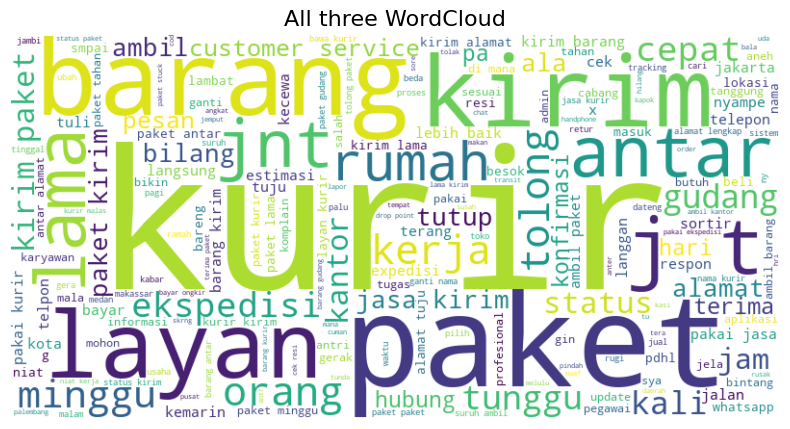

In [72]:
generate_wordcloud(jelek_eda_df['processed_reviews'], 'All three WordCloud')

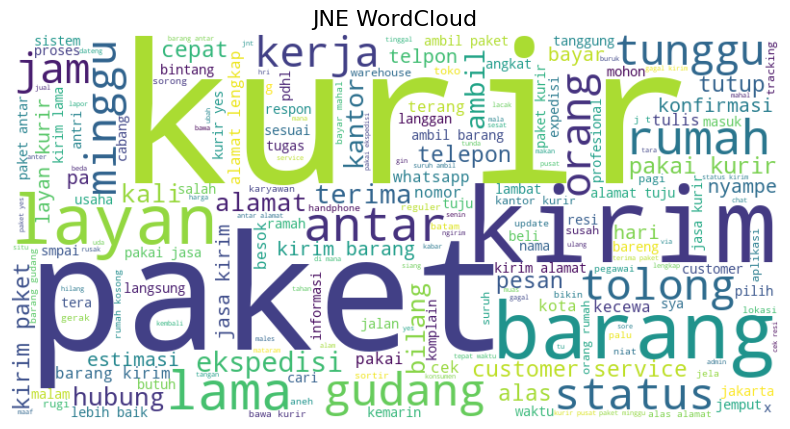

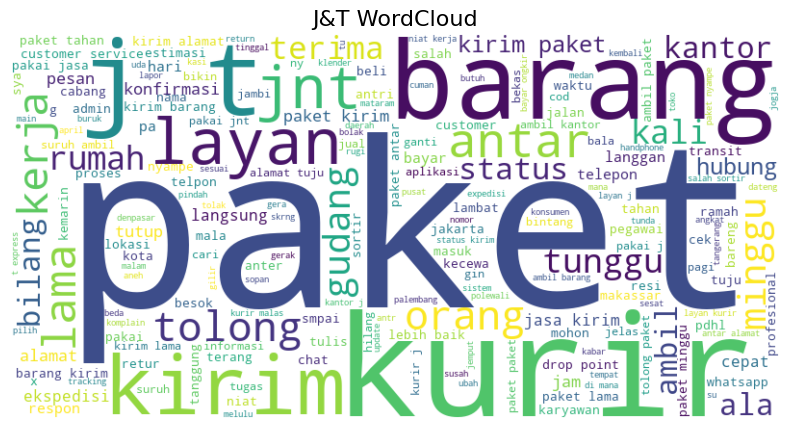

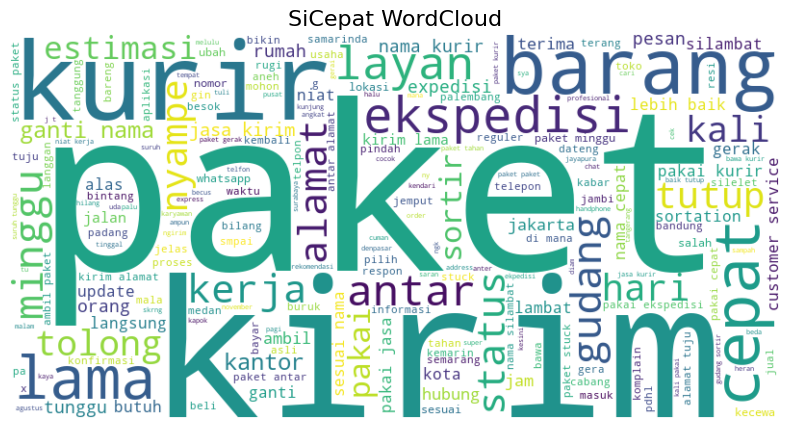

In [73]:
# Generate word clouds for each company
generate_wordcloud(jne_df['processed_reviews'], 'JNE WordCloud')
generate_wordcloud(jnt_df['processed_reviews'], 'J&T WordCloud')
generate_wordcloud(sicepat_df['processed_reviews'], 'SiCepat WordCloud')

In [74]:
# check most used stopwords
## def function

def analyze_most_used_words(df, column, top_n=20):
    '''
    Check n top_n of most common words used.
    df = data
    column = column to be processed
    top_n = show top n words 
    '''
    # Tokenize the column into words
    df['words_list'] = df[column].apply(lambda x: str(x).split())
    
    # Flatten the list of lists and count word frequencies
    word_counts = Counter([word for words in df['words_list'] for word in words])
    
    # Create a DataFrame with the top N most common words
    most_common_df = pd.DataFrame(word_counts.most_common(top_n), columns=['word', 'count'])
    
    # Display the table with a gradient background for visualization
    return most_common_df.style.background_gradient(cmap='Blues')

In [75]:
print("Most Used Words for all three:")
analyze_most_used_words(jelek_eda_df, 'processed_reviews')

Most Used Words for all three:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,paket,8084
1,kurir,6394
2,kirim,5622
3,barang,4623
4,layan,2652
5,lama,1810
6,antar,1694
7,alamat,1682
8,pakai,1628
9,ambil,1387


In [76]:
print("Most Used Words for JNE:")
analyze_most_used_words(jne_df, 'processed_reviews')

Most Used Words for JNE:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,kurir,3426
1,paket,2522
2,kirim,2146
3,barang,1825
4,layan,1143
5,alamat,780
6,pakai,624
7,antar,613
8,lama,604
9,rumah,604


In [77]:
print("Most Used Words for J&T:")
analyze_most_used_words(jnt_df, 'processed_reviews')

Most Used Words for J&T:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,paket,3581
1,kirim,2210
2,barang,1943
3,kurir,1708
4,layan,1218
5,j,1139
6,t,1126
7,jnt,1015
8,antar,726
9,lama,686


In [78]:
print("Most Used Words for SiCepat:")
analyze_most_used_words(sicepat_df, 'processed_reviews')

Most Used Words for SiCepat:


C:\Users\Niko Amrullah Hakam\AppData\Local\Temp\ipykernel_4104\1013743734.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words_list'] = df[column].apply(lambda x: str(x).split())


,word,count
0,paket,1981
1,kirim,1266
2,kurir,1260
3,barang,855
4,cepat,619
5,lama,520
6,nama,496
7,pakai,495
8,ekspedisi,420
9,alamat,382


In [79]:
# bigrams trigrams func

def get_ngrams(df, column, ngram_range, max_features=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    ngrams = vectorizer.fit_transform(df[column])
    return vectorizer.get_feature_names_out()

In [80]:
for company in jelek_eda_df['company'].str.lower().unique():
    print(f"\nTop 10 BIgrams for {company}:")
    bigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (2, 2))
    print(bigrams)
    
    print(f"\nTop 10 TRIgrams for {company}:")
    trigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (3, 3))
    print(trigrams)


Top 10 BIgrams for jne:
['barang kirim' 'customer service' 'jasa kirim' 'kirim barang'
 'kirim kurir' 'kirim paket' 'kurir kurir' 'layan kurir' 'pakai kurir'
 'paket kirim']

Top 10 TRIgrams for jne:
['alas alamat lengkap' 'antar alamat tuju' 'customer service kurir'
 'jasa kirim kurir' 'kirim alamat tuju' 'lebih baik tutup'
 'nobody at home' 'pakai jasa kirim' 'pakai jasa kurir' 'pakai kurir yes']

Top 10 BIgrams for jnt:
['ambil paket' 'barang kirim' 'customer service' 'drop point' 'jasa kirim'
 'kirim barang' 'kirim paket' 'lebih baik' 'paket antar' 'paket kirim']

Top 10 TRIgrams for jnt:
['ambil paket kantor' 'antar alamat tuju' 'bayar ongkir mahal'
 'lebih baik pakai' 'lebih baik tutup' 'makan gaji buta'
 'pakai jasa kirim' 'paket bawa kurir' 'paket kirim kirim'
 'suruh ambil kantor']

Top 10 BIgrams for sicepat:
['customer service' 'ganti nama' 'jasa kirim' 'kirim paket' 'lebih baik'
 'nama cepat' 'nama kurir' 'pakai jasa' 'pakai kurir' 'paket kirim']

Top 10 TRIgrams for sicep

---

# 5. Attempt Feature preps

In [85]:
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [83]:
# let's copy df
modeling_df = eda_df.copy()

In [84]:
modeling_df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just around the corner from Siti Nurbaya Bridge across Batang Anai River. JNE is one of many delivery services in Indonesia. Giving good services, the business entity continues to grow.",JNE,Aceh,2024-04-24,letak kawasan kota tua padang jembatan siti nurbaya seberang sungai batang ana kurir salah layan kirim indonesia layan badan usaha kembang
1,1,"Bad service given to customers, my own experience taking 1 day shipment service and had to pay quite big amount of money. I asked over and over to make sure my package arrived in 1 day as it contained food and JNE staffs answer so sure it …",JNE,Aceh,2021-01-20,layan langgan alam ambil jasa kirim keluar biaya kali kali paket isi makan tugas kurir
2,5,"Nice Place, they're working on rebuild their office, great people and services",JNE,Aceh,2022-01-20,upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this country.,JNE,Aceh,2023-01-20,layan kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-20,layan
...,...,...,...,...,...,...
17663,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-20,kargo silambat
17664,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-20,silelet cembret
17665,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-20,NaN
17666,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-20,keras
